In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# === CONFIG ===
DATA_DIR = "/kaggle/input/asl-dataset-rerain/dataset_retrain"
CLASS_NAMES_FILE = "/kaggle/working/class_names.txt"
MODEL_SAVE_PATH = "/kaggle/working/asl-detector-retrained-v4.h5"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

# === Tạo class_names.txt ===
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
with open(CLASS_NAMES_FILE, "w") as f:
    for name in class_names:
        f.write(name + "\n")
print(f"📁 Đã ghi {len(class_names)} lớp vào {CLASS_NAMES_FILE}")

# === GPU Strategy ===
gpus = tf.config.list_physical_devices('GPU')
print(f"🖥️ Số lượng GPU tìm thấy: {len(gpus)}")
strategy = tf.distribute.MirroredStrategy()

# === Data Augmentation ===
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.6, 1.4),
    shear_range=0.2,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# === Tính class_weight cho training data ===
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("⚖️ class_weights =", class_weights)

# === Build model in strategy scope ===
with strategy.scope():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
    base_model.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)
    output = Dense(len(class_names), activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

# === Train model ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
    ]
)

# === Save model ===
model.save(MODEL_SAVE_PATH)
print(f"✅ Model đã lưu vào {MODEL_SAVE_PATH}")

2025-05-09 00:26:52.205313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746750412.675368      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746750412.805208      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📁 Đã ghi 24 lớp vào /kaggle/working/class_names.txt
🖥️ Số lượng GPU tìm thấy: 2


I0000 00:00:1746750431.734397      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746750431.735128      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5144 images belonging to 24 classes.
Found 1272 images belonging to 24 classes.
⚖️ class_weights = {0: 0.6913978494623656, 1: 0.7793939393939394, 2: 1.1461675579322639, 3: 0.8930555555555556, 4: 1.0015576323987538, 5: 1.2178030303030303, 6: 1.025518341307815, 7: 1.4884259259259258, 8: 1.2109227871939736, 9: 0.948377581120944, 10: 1.3149284253578732, 11: 1.2389210019267822, 12: 0.8180661577608143, 13: 1.0824915824915824, 14: 0.9922839506172839, 15: 0.676130389064143, 16: 0.9238505747126436, 17: 0.9238505747126436, 18: 0.8027465667915106, 19: 1.2389210019267822, 20: 0.9568452380952381, 21: 0.9120567375886525, 22: 1.0404530744336569, 23: 2.4356060606060606}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1746750487.770821      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746750487.770841      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


322/322 ━━━━━━━━━━━━━━━━━━━━ 178s 418ms/step - accuracy: 0.0487 - loss: 3.5335 - val_accuracy: 0.0755 - val_loss: 3.2620
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 98s 298ms/step - accuracy: 0.1211 - loss: 2.9931 - val_accuracy: 0.1132 - val_loss: 3.0886
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 98s 299ms/step - accuracy: 0.2627 - loss: 2.5194 - val_accuracy: 0.1258 - val_loss: 3.0249
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 295ms/step - accuracy: 0.4487 - loss: 1.9519 - val_accuracy: 0.1274 - val_loss: 2.9699
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 294ms/step - accuracy: 0.5887 - loss: 1.4863 - val_accuracy: 0.2013 - val_loss: 2.6240
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 294ms/step - accuracy: 0.7102 - loss: 1.0929 - val_accuracy: 0.3491 - val_loss: 2.1157
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 294ms/step - accuracy: 0.7741 - loss: 0.8316 - val_accuracy: 0.5362 - val_loss: 1.5273
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 294ms/step - accuracy: 0.8218 - loss: 0.6451 - va

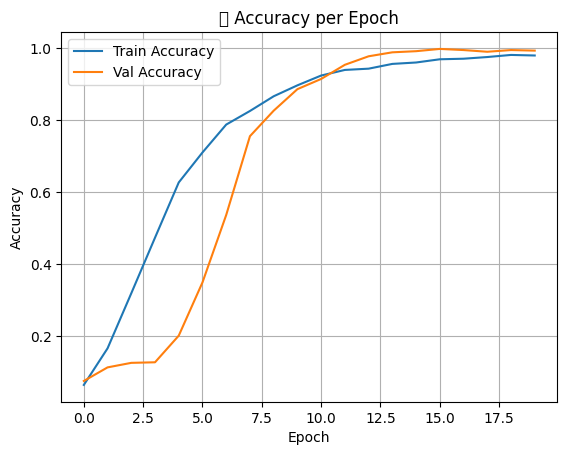

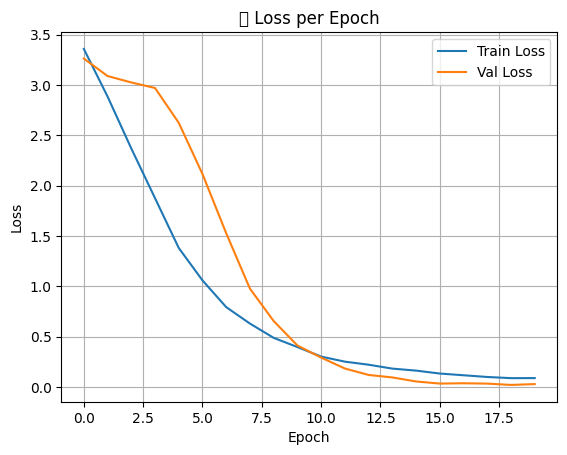

In [4]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('📈 Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('📉 Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           a       1.00      0.96      0.98        77
           b       1.00      0.99      0.99        68
           c       1.00      1.00      1.00        46
           d       1.00      1.00      1.00        59
           e       1.00      1.00      1.00        53
           f       0.98      1.00      0.99        43
           g       1.00      1.00      1.00        52
           h       1.00      1.00      1.00        35
           i       1.00      1.00      1.00        44
           k       1.00      1.00      1.00        56
           l       0.98      1.00      0.99        40
           m       1.00      1.00      1.00        43
           n       0.98      1.00      0.99        65
           o       1.00      1.00      1.00        49
           p       1.00      1.00      1.00        54
           r       1.00      1.00      1.00        79
           s 

,a,b,c,d,e,f,g,h,i,k,...,p,r,s,t,u,v,w,x,y,z
a,74,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
b,0,67,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c,0,0,46,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d,0,0,0,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,53,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f,0,0,0,0,0,43,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g,0,0,0,0,0,0,52,0,0,0,...,0,0,0,0,0,0,0,0,0,0
h,0,0,0,0,0,0,0,35,0,0,...,0,0,0,0,0,0,0,0,0,0
i,0,0,0,0,0,0,0,0,44,0,...,0,0,0,0,0,0,0,0,0,0
k,0,0,0,0,0,0,0,0,0,56,...,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


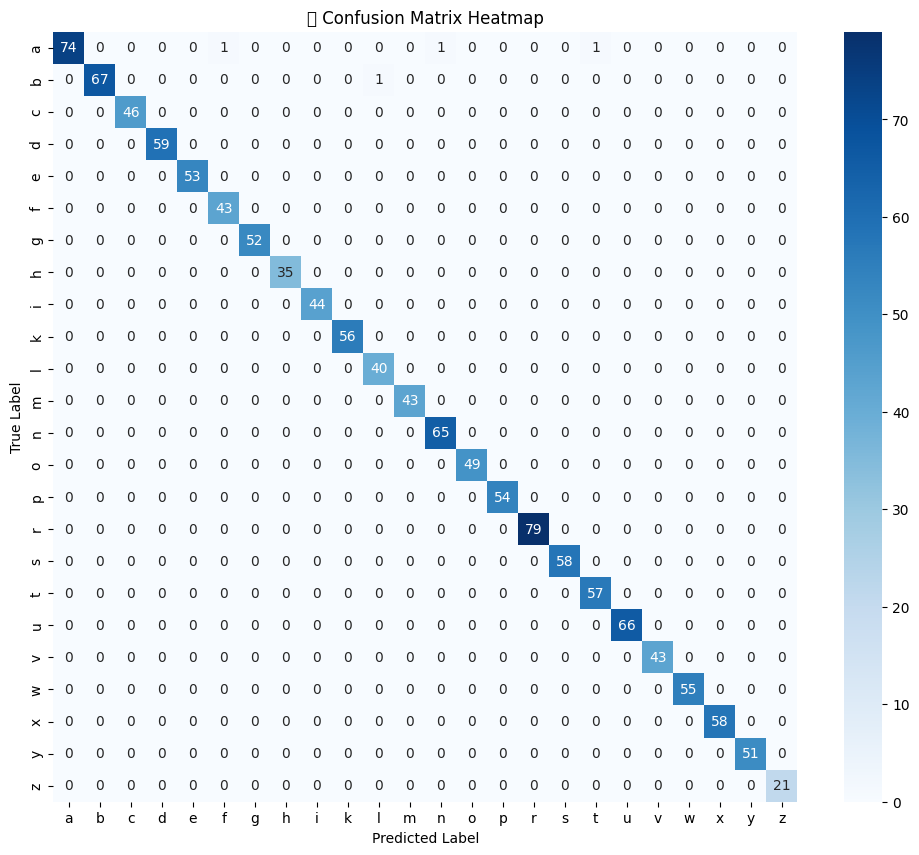

In [5]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Predict labels
val_gen.reset()
Y_pred = model.predict(val_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to DataFrame for better display
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Display confusion matrix table
print("🧾 Confusion Matrix Table:")
display(cm_df)

# Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("📌 Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()